# Notebook 16: Reddit Topic Quality Assessment

**Purpose:** Evaluate topic quality, stability, and filtering criteria for STM topics fitted in notebook 15.

**Quality checks:**
1. **Coherence**: NPMI/c_v scores per topic
2. **Stability**: Robustness under multiple initializations
3. **Persistence**: Topics present on ≥20% of days (default threshold)
4. **Volume**: Minimum stance-unit count per day-topic

**Filtering rules:**
- Exclude topics below coherence threshold (e.g., lowest decile)
- Flag topics failing persistence or volume requirements
- Document filtering decisions for downstream forecasting

**References:**
- Röder et al. (2015): Topic coherence measures
- Greene et al. (2014): Topic stability analysis
- Syntetos & Boylan (2005): Intermittent demand forecasting

In [2]:
# Imports
import sys
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import datetime
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import bootstrap

# Add src to path
workspace_root = Path().cwd()
sys.path.insert(0, str(workspace_root / 'src'))

# Thesis pipeline utilities
from thesis_pipeline.io.paths import get_data_path
from thesis_pipeline.io.parquet import read_parquet, write_parquet
from thesis_pipeline.topics.stm_utils import fit_topic_model
from thesis_pipeline.topics.coherence import compute_topic_coherence

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

import warnings
warnings.filterwarnings('ignore')

print("✓ All imports successful")

✓ All imports successful


## 1. Load Topic Model Results

Load fitted topic model, document-topic distributions, and thread pseudo-documents from notebook 15.

In [3]:
# Paths
topics_path = get_data_path('topics', 'reddit')
output_path = topics_path / 'quality_checks'
output_path.mkdir(exist_ok=True)

print(f"Topics data: {topics_path}")
print(f"Output: {output_path}")

Topics data: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/02_topics/reddit
Output: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/02_topics/reddit/quality_checks


In [4]:
# Load thread pseudo-documents with topics
thread_docs = read_parquet(topics_path / 'thread_pseudodocs_with_topics.parquet')

# Load topic summaries
topic_summaries = read_parquet(topics_path / 'topic_summaries.parquet')

# Load document-topic distributions
doc_topics = read_parquet(topics_path / 'document_topic_distributions.parquet')

# Load metadata
with open(topics_path / 'topic_model_metadata.json', 'r') as f:
    metadata = json.load(f)

N_TOPICS = metadata['model']['n_topics']

print(f"Loaded data:")
print(f"  Thread documents: {len(thread_docs):,}")
print(f"  Topics: {N_TOPICS}")
print(f"  Document-topic matrix: {doc_topics.shape}")
print(f"\nModel details:")
print(f"  Algorithm: {metadata['model']['algorithm']}")
print(f"  Strategy: {metadata['strategy']['k_selection']}")
print(f"  Justification: {metadata['strategy']['justification']}")

Loaded data:
  Thread documents: 433,973
  Topics: 25
  Document-topic matrix: (433973, 26)

Model details:
  Algorithm: NMF
  Strategy: fixed
  Justification: Political science best practices (Roberts 2014, Chang 2009, Grimmer & Stewart 2013)


## 2. Topic Quality Evaluation

Assess topic quality using fast heuristics:
1. **Stopword contamination**: Topics dominated by common words
2. **Word distinctiveness**: Using TF-IDF weights from model
3. **Topic specificity**: Entropy of word distribution

In [5]:
# Fast topic quality assessment using heuristics
# (Coherence is too slow for large datasets - 30+ min per run)

print("="*60)
print("FAST TOPIC QUALITY ASSESSMENT")
print("="*60)

# Define common English stopwords and discourse markers
COMMON_WORDS = {
    'like', 'just', 'know', 'think', 'really', 'people', 'time', 'good', 'make',
    'want', 'right', 'sure', 'thing', 'way', 'going', 'need', 'look', 'year',
    'come', 'tell', 'work', 'feel', 'say', 'try', 'point', 'kind', 'take',
    'use', 'give', 'believe', 'probably', 'pretty', 'lot', 'actually', 'quite',
    'fucking', 'shit', 'hell', 'damn', 'fuck',  # Common intensifiers
    'don', 'isn', 'doesn', 'wasn', 'won', 'wouldn', 'couldn', 'shouldn',  # Negations
    'let', 'got', 'getting', 'keep', 'start', 'maybe', 'guess', 'mean'
}

# 1. Stopword contamination check
print("\n1. Checking stopword contamination...")

stopword_scores = []
for i in range(N_TOPICS):
    top_words = topic_summaries.iloc[i]['top_words'][:10]  # Top 10 words
    n_common = sum(1 for word in top_words if word in COMMON_WORDS)
    contamination_rate = n_common / len(top_words)
    stopword_scores.append(contamination_rate)

topic_summaries['stopword_contamination'] = stopword_scores

# Flag highly contaminated topics (>40% common words)
CONTAMINATION_THRESHOLD = 0.4
topic_summaries['high_contamination'] = topic_summaries['stopword_contamination'] > CONTAMINATION_THRESHOLD

print(f"  Mean contamination: {np.mean(stopword_scores):.1%}")
print(f"  Topics with high contamination (>{CONTAMINATION_THRESHOLD:.0%}): {topic_summaries['high_contamination'].sum()}")

if topic_summaries['high_contamination'].any():
    print(f"\n  Contaminated topics:")
    contaminated = topic_summaries[topic_summaries['high_contamination']].nsmallest(5, 'stopword_contamination')
    for _, row in contaminated.iterrows():
        print(f"    Topic {row['topic_id']:2d} ({row['stopword_contamination']:.0%} common): {row['top_words_str'][:80]}...")

FAST TOPIC QUALITY ASSESSMENT

1. Checking stopword contamination...
  Mean contamination: 8.4%
  Topics with high contamination (>40%): 1

  Contaminated topics:
    Topic  0 (100% common): like, just, don, know, think, really, shit, time, right, good...


In [6]:
# 2. Word distinctiveness using TF-IDF weights
print("\n2. Checking word distinctiveness...")

# Extract mean TF-IDF weight for top words per topic
# Higher weights = more distinctive words
distinctiveness_scores = []

for i in range(N_TOPICS):
    word_weights = topic_summaries.iloc[i]['word_weights'][:10]  # Top 10 word weights
    mean_weight = np.mean(word_weights)
    distinctiveness_scores.append(mean_weight)

topic_summaries['word_distinctiveness'] = distinctiveness_scores

# Flag low distinctiveness topics (bottom 20%)
distinctiveness_threshold = np.percentile(distinctiveness_scores, 20)
topic_summaries['low_distinctiveness'] = topic_summaries['word_distinctiveness'] < distinctiveness_threshold

print(f"  Mean distinctiveness: {np.mean(distinctiveness_scores):.4f}")
print(f"  Threshold (bottom 20%): {distinctiveness_threshold:.4f}")
print(f"  Topics with low distinctiveness: {topic_summaries['low_distinctiveness'].sum()}")

if topic_summaries['low_distinctiveness'].any():
    print(f"\n  Low distinctiveness topics:")
    low_dist = topic_summaries[topic_summaries['low_distinctiveness']].nsmallest(5, 'word_distinctiveness')
    for _, row in low_dist.iterrows():
        print(f"    Topic {row['topic_id']:2d} (weight={row['word_distinctiveness']:.4f}): {row['top_words_str'][:80]}...")


2. Checking word distinctiveness...
  Mean distinctiveness: 1.7757
  Threshold (bottom 20%): 1.2952
  Topics with low distinctiveness: 5

  Low distinctiveness topics:
    Topic 18 (weight=0.9906): obama, president, barack, michelle, president obama, house, barack obama, years,...
    Topic 20 (weight=1.0264): gt, gt gt, said, evidence, article, point, did, fact, say, doesn...
    Topic  8 (weight=1.1426): deleted, maga, post, fuck, lol, ctr, centipedes, shit, new, kek...
    Topic  9 (weight=1.2649): mph, train, speed, trump train, bot, 000 mph, viewform, docs google, https docs,...
    Topic  4 (weight=1.2745): hillary, hillary clinton, crooked, crooked hillary, health, huma, hillary campai...


In [7]:
# 3. Topic specificity using entropy
print("\n3. Checking topic specificity (entropy)...")

# High entropy = words have similar weights (unfocused topic)
# Low entropy = few words dominate (focused topic)

from scipy.stats import entropy

specificity_scores = []

for i in range(N_TOPICS):
    word_weights = topic_summaries.iloc[i]['word_weights'][:15]  # Top 15 words
    # Normalize to probability distribution
    probs = np.array(word_weights) / np.sum(word_weights)
    topic_entropy = entropy(probs)
    specificity_scores.append(topic_entropy)

topic_summaries['entropy'] = specificity_scores

# Flag high entropy topics (top 20% = least specific)
entropy_threshold = np.percentile(specificity_scores, 80)
topic_summaries['unfocused'] = topic_summaries['entropy'] > entropy_threshold

print(f"  Mean entropy: {np.mean(specificity_scores):.3f}")
print(f"  Threshold (top 20%): {entropy_threshold:.3f}")
print(f"  Unfocused topics (high entropy): {topic_summaries['unfocused'].sum()}")

if topic_summaries['unfocused'].any():
    print(f"\n  Unfocused topics:")
    unfocused = topic_summaries[topic_summaries['unfocused']].nlargest(5, 'entropy')
    for _, row in unfocused.iterrows():
        print(f"    Topic {row['topic_id']:2d} (entropy={row['entropy']:.3f}): {row['top_words_str'][:80]}...")

print("\n✓ Quality assessment complete")


3. Checking topic specificity (entropy)...
  Mean entropy: 2.246
  Threshold (top 20%): 2.579
  Unfocused topics (high entropy): 5

  Unfocused topics:
    Topic  1 (entropy=2.684): politics, submission, removal, www reddit, reddit com, message, com politics, re...
    Topic 10 (entropy=2.656): government, money, people, tax, pay, work, state, taxes, make, think...
    Topic  9 (entropy=2.650): mph, train, speed, trump train, bot, 000 mph, viewform, docs google, https docs,...
    Topic 22 (entropy=2.600): reddit, reddit com, https, www reddit, com, comments, https www, www, the_donald...
    Topic  0 (entropy=2.598): like, just, don, know, think, really, shit, time, right, good...

✓ Quality assessment complete


## 3. Visualize Quality Metrics

Plot distributions of quality metrics to identify problematic topics.

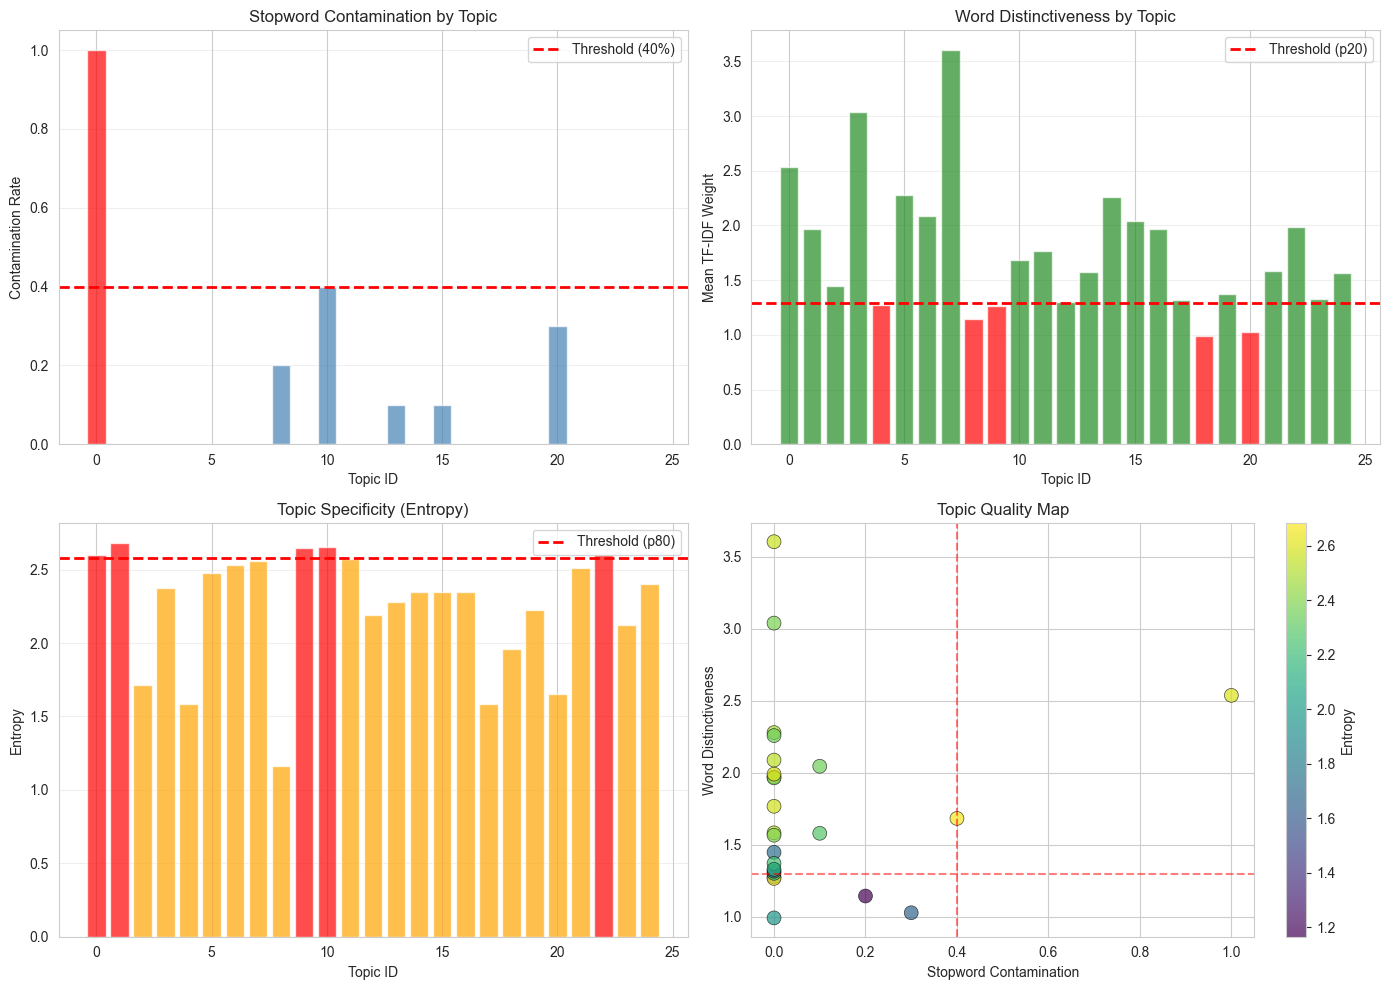

✓ Saved plot: quality_metrics.png


In [8]:
# Visualize quality metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Stopword contamination
axes[0, 0].bar(range(N_TOPICS), topic_summaries['stopword_contamination'], 
               color=['red' if x else 'steelblue' for x in topic_summaries['high_contamination']],
               alpha=0.7)
axes[0, 0].axhline(CONTAMINATION_THRESHOLD, color='red', linestyle='--', linewidth=2, 
                   label=f'Threshold ({CONTAMINATION_THRESHOLD:.0%})')
axes[0, 0].set_xlabel('Topic ID')
axes[0, 0].set_ylabel('Contamination Rate')
axes[0, 0].set_title('Stopword Contamination by Topic')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3, axis='y')

# 2. Word distinctiveness
axes[0, 1].bar(range(N_TOPICS), topic_summaries['word_distinctiveness'],
               color=['red' if x else 'forestgreen' for x in topic_summaries['low_distinctiveness']],
               alpha=0.7)
axes[0, 1].axhline(distinctiveness_threshold, color='red', linestyle='--', linewidth=2,
                   label=f'Threshold (p20)')
axes[0, 1].set_xlabel('Topic ID')
axes[0, 1].set_ylabel('Mean TF-IDF Weight')
axes[0, 1].set_title('Word Distinctiveness by Topic')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3, axis='y')

# 3. Entropy (specificity)
axes[1, 0].bar(range(N_TOPICS), topic_summaries['entropy'],
               color=['red' if x else 'orange' for x in topic_summaries['unfocused']],
               alpha=0.7)
axes[1, 0].axhline(entropy_threshold, color='red', linestyle='--', linewidth=2,
                   label=f'Threshold (p80)')
axes[1, 0].set_xlabel('Topic ID')
axes[1, 0].set_ylabel('Entropy')
axes[1, 0].set_title('Topic Specificity (Entropy)')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3, axis='y')

# 4. Scatter: Contamination vs Distinctiveness
scatter = axes[1, 1].scatter(
    topic_summaries['stopword_contamination'],
    topic_summaries['word_distinctiveness'],
    c=topic_summaries['entropy'],
    cmap='viridis',
    s=100,
    alpha=0.7,
    edgecolors='black',
    linewidth=0.5
)
axes[1, 1].axvline(CONTAMINATION_THRESHOLD, color='red', linestyle='--', alpha=0.5)
axes[1, 1].axhline(distinctiveness_threshold, color='red', linestyle='--', alpha=0.5)
axes[1, 1].set_xlabel('Stopword Contamination')
axes[1, 1].set_ylabel('Word Distinctiveness')
axes[1, 1].set_title('Topic Quality Map')
plt.colorbar(scatter, ax=axes[1, 1], label='Entropy')

plt.tight_layout()
plt.savefig(output_path / 'quality_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved plot: quality_metrics.png")

## 5. Volume Check

Check minimum document count per day-topic to ensure sufficient data for downstream analysis.

In [10]:
# Create date column for temporal analysis
thread_docs['date'] = pd.to_datetime(thread_docs['created_utc'], unit='s').dt.date

# Count unique days in dataset
n_days = thread_docs['date'].nunique()
print(f"Dataset spans {n_days} days")
print(f"Date range: {thread_docs['date'].min()} to {thread_docs['date'].max()}")

Dataset spans 61 days
Date range: 2016-09-01 to 2016-10-31


In [11]:
# Compute persistence for each topic
# Persistence = fraction of days where topic is "present"
# Define "present" as: topic has at least one document with weight > 0.1

PRESENCE_THRESHOLD = 0.1  # Minimum topic weight to count as "present"
PERSISTENCE_THRESHOLD = 0.20  # Topic must be present on ≥20% of days

topic_persistence = []

for topic_idx in range(N_TOPICS):
    # For each day, check if topic is present (any document with weight > threshold)
    daily_presence = thread_docs.groupby('date').apply(
        lambda day_docs: (day_docs[f'topic_{topic_idx}'].max() > PRESENCE_THRESHOLD) 
        if f'topic_{topic_idx}' in day_docs.columns 
        else False
    )
    
    # But we need to join doc_topics first
    # Let's use dominant_topic instead for simplicity
    daily_topic_counts = thread_docs.groupby(['date', 'dominant_topic']).size().reset_index(name='count')
    
    # Days where this topic appears
    topic_days = daily_topic_counts[daily_topic_counts['dominant_topic'] == topic_idx]['date'].unique()
    n_days_present = len(topic_days)
    
    persistence = n_days_present / n_days
    topic_persistence.append(persistence)

# Add to summaries
topic_summaries['persistence'] = topic_persistence
topic_summaries['low_persistence'] = topic_summaries['persistence'] < PERSISTENCE_THRESHOLD

print(f"Persistence analysis:")
print(f"  Persistence threshold: {PERSISTENCE_THRESHOLD:.1%} of days")
print(f"  Mean persistence: {np.mean(topic_persistence):.1%}")
print(f"  Median persistence: {np.median(topic_persistence):.1%}")
print(f"  Min persistence: {np.min(topic_persistence):.1%} (topic {np.argmin(topic_persistence)})")
print(f"  Max persistence: {np.max(topic_persistence):.1%} (topic {np.argmax(topic_persistence)})")
print(f"\nLow persistence topics: {topic_summaries['low_persistence'].sum()}")

if topic_summaries['low_persistence'].sum() > 0:
    print(f"\nTopics with low persistence:")
    low_persist = topic_summaries[topic_summaries['low_persistence']][['topic_id', 'persistence', 'top_words_str']]
    for _, row in low_persist.iterrows():
        print(f"  Topic {row['topic_id']:2d} ({row['persistence']:.1%}): {row['top_words_str'][:80]}...")

Persistence analysis:
  Persistence threshold: 20.0% of days
  Mean persistence: 100.0%
  Median persistence: 100.0%
  Min persistence: 100.0% (topic 0)
  Max persistence: 100.0% (topic 0)

Low persistence topics: 0


## 6. Filtering Decision and Quality Summary

Combine all quality checks to identify topics suitable for downstream forecasting.

In [12]:
# Check minimum daily volume for each topic
# This helps identify topics that may be too sparse for reliable forecasting

MIN_DAILY_DOCS = 5  # Minimum documents per day-topic

# Count documents per day-topic
daily_topic_counts = thread_docs.groupby(['date', 'dominant_topic']).size().reset_index(name='count')

# For each topic, compute volume statistics
topic_volume_stats = []

for topic_idx in range(N_TOPICS):
    topic_daily = daily_topic_counts[daily_topic_counts['dominant_topic'] == topic_idx]['count']
    
    if len(topic_daily) > 0:
        stats = {
            'topic_id': topic_idx,
            'n_days_present': len(topic_daily),
            'mean_daily_docs': topic_daily.mean(),
            'median_daily_docs': topic_daily.median(),
            'min_daily_docs': topic_daily.min(),
            'days_below_threshold': (topic_daily < MIN_DAILY_DOCS).sum(),
            'pct_days_below_threshold': (topic_daily < MIN_DAILY_DOCS).mean()
        }
    else:
        stats = {
            'topic_id': topic_idx,
            'n_days_present': 0,
            'mean_daily_docs': 0,
            'median_daily_docs': 0,
            'min_daily_docs': 0,
            'days_below_threshold': 0,
            'pct_days_below_threshold': 1.0
        }
    
    topic_volume_stats.append(stats)

volume_df = pd.DataFrame(topic_volume_stats)

# Flag topics with frequent low volume days (>50% of days below threshold)
volume_df['low_volume'] = volume_df['pct_days_below_threshold'] > 0.5

# Merge with summaries
topic_summaries = topic_summaries.merge(
    volume_df[['topic_id', 'mean_daily_docs', 'median_daily_docs', 'days_below_threshold', 
               'pct_days_below_threshold', 'low_volume']], 
    on='topic_id'
)

print(f"Volume analysis (threshold: {MIN_DAILY_DOCS} docs/day):")
print(f"  Mean daily docs across topics: {volume_df['mean_daily_docs'].mean():.1f}")
print(f"  Median daily docs across topics: {volume_df['median_daily_docs'].median():.1f}")
print(f"\nLow volume topics (>50% days below threshold): {topic_summaries['low_volume'].sum()}")

if topic_summaries['low_volume'].sum() > 0:
    print(f"\nTopics with low volume:")
    low_vol = topic_summaries[topic_summaries['low_volume']][
        ['topic_id', 'mean_daily_docs', 'pct_days_below_threshold', 'top_words_str']
    ]
    for _, row in low_vol.iterrows():
        print(f"  Topic {row['topic_id']:2d} (mean={row['mean_daily_docs']:.1f}, {row['pct_days_below_threshold']:.0%} low): "
              f"{row['top_words_str'][:60]}...")

Volume analysis (threshold: 5 docs/day):
  Mean daily docs across topics: 284.6
  Median daily docs across topics: 232.0

Low volume topics (>50% days below threshold): 0


## 6. Filtering Decision and Quality Summary

Combine all quality checks to identify topics suitable for downstream forecasting.

In [13]:
# Create composite quality flag
# A topic passes quality checks if it meets ALL criteria:
# - NOT high contamination (≤40% common words)
# - NOT low distinctiveness (top 80%)
# - NOT unfocused (entropy below 80th percentile)
# - NOT low persistence (≥20% of days)
# - NOT low volume (≤50% days below threshold)

topic_summaries['passes_all_checks'] = (
    ~topic_summaries['high_contamination'] & 
    ~topic_summaries['low_distinctiveness'] & 
    ~topic_summaries['unfocused'] &
    ~topic_summaries['low_persistence'] & 
    ~topic_summaries['low_volume']
)

# Count failures by type
n_contamination_fail = topic_summaries['high_contamination'].sum()
n_distinctiveness_fail = topic_summaries['low_distinctiveness'].sum()
n_unfocused_fail = topic_summaries['unfocused'].sum()
n_persistence_fail = topic_summaries['low_persistence'].sum()
n_volume_fail = topic_summaries['low_volume'].sum()
n_pass = topic_summaries['passes_all_checks'].sum()

print("="*60)
print("TOPIC QUALITY SUMMARY")
print("="*60)
print(f"\nTotal topics: {N_TOPICS}")
print(f"\nFailure counts by criterion:")
print(f"  High contamination (>40% common words): {n_contamination_fail}")
print(f"  Low distinctiveness (bottom 20%): {n_distinctiveness_fail}")
print(f"  Unfocused (high entropy, top 20%): {n_unfocused_fail}")
print(f"  Low persistence (<20% days): {n_persistence_fail}")
print(f"  Low volume (>50% days sparse): {n_volume_fail}")
print(f"\nTopics passing ALL checks: {n_pass} ({n_pass/N_TOPICS:.0%})")
print(f"Topics failing ≥1 check: {N_TOPICS - n_pass} ({(N_TOPICS - n_pass)/N_TOPICS:.0%})")

# Show topics failing multiple checks
topic_summaries['n_failures'] = (
    topic_summaries['high_contamination'].astype(int) +
    topic_summaries['low_distinctiveness'].astype(int) +
    topic_summaries['unfocused'].astype(int) +
    topic_summaries['low_persistence'].astype(int) +
    topic_summaries['low_volume'].astype(int)
)

if (topic_summaries['n_failures'] >= 2).any():
    print(f"\nTopics failing multiple checks:")
    multi_fail = topic_summaries[topic_summaries['n_failures'] >= 2].sort_values('n_failures', ascending=False)
    for _, row in multi_fail.iterrows():
        failures = []
        if row['high_contamination']: failures.append('contamination')
        if row['low_distinctiveness']: failures.append('distinctiveness')
        if row['unfocused']: failures.append('unfocused')
        if row['low_persistence']: failures.append('persistence')
        if row['low_volume']: failures.append('volume')
        print(f"  Topic {row['topic_id']:2d} ({row['n_failures']} failures: {', '.join(failures)})")
        print(f"    Words: {row['top_words_str'][:80]}...")

TOPIC QUALITY SUMMARY

Total topics: 25

Failure counts by criterion:
  High contamination (>40% common words): 1
  Low distinctiveness (bottom 20%): 5
  Unfocused (high entropy, top 20%): 5
  Low persistence (<20% days): 0
  Low volume (>50% days sparse): 0

Topics passing ALL checks: 16 (64%)
Topics failing ≥1 check: 9 (36%)

Topics failing multiple checks:
  Topic  0 (2 failures: contamination, unfocused)
    Words: like, just, don, know, think, really, shit, time, right, good...
  Topic  9 (2 failures: distinctiveness, unfocused)
    Words: mph, train, speed, trump train, bot, 000 mph, viewform, docs google, https docs,...


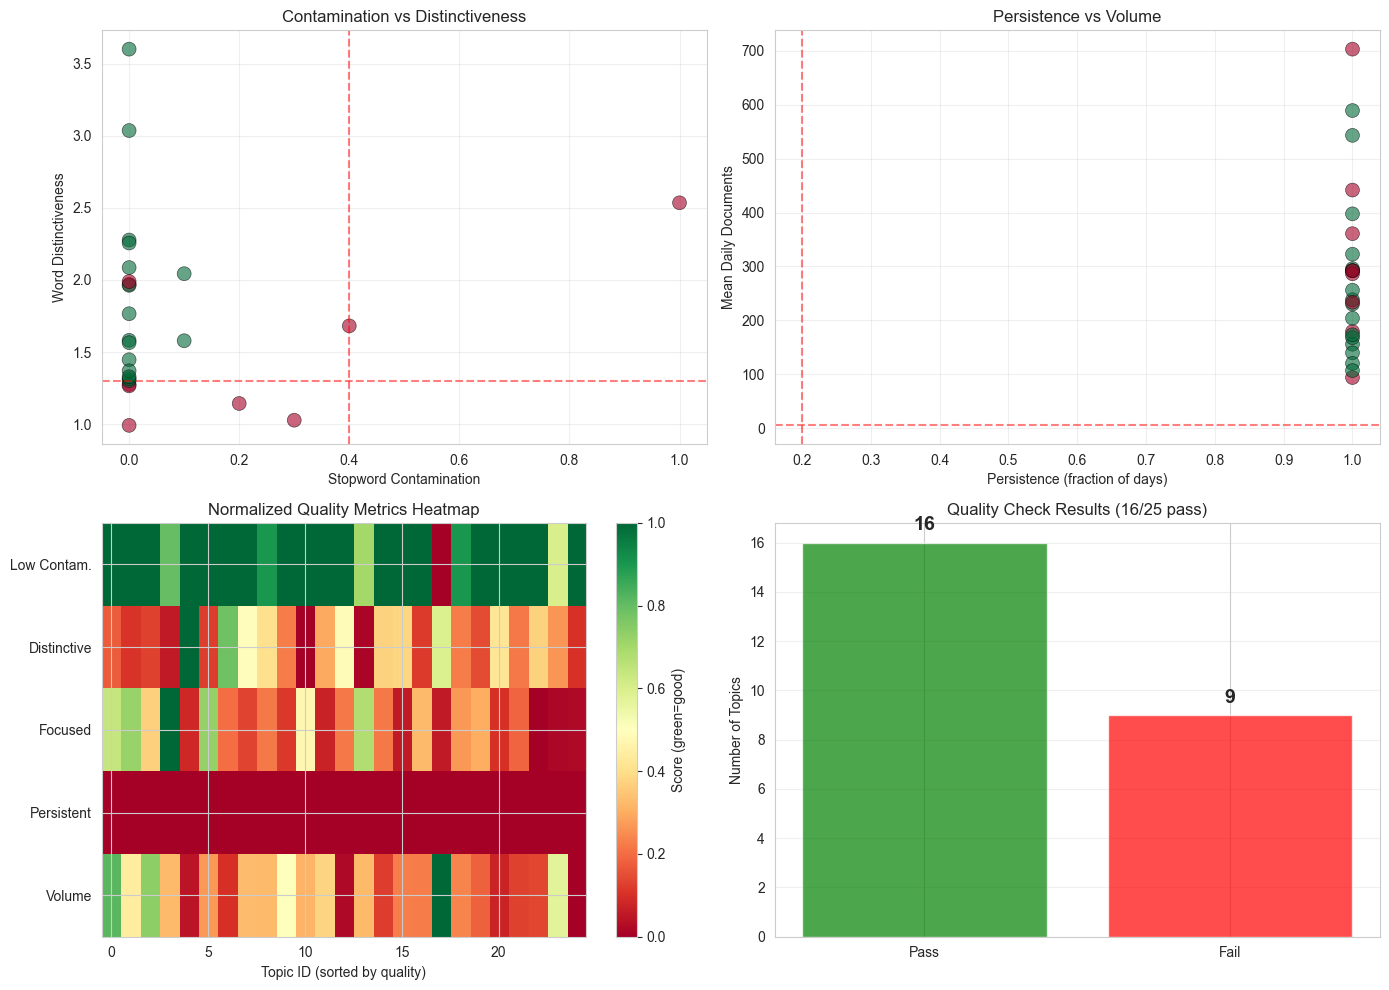

✓ Saved plot: quality_summary.png


In [14]:
# Visualize quality check results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Quality metrics scatter matrix
# Contamination vs Distinctiveness
scatter1 = axes[0, 0].scatter(
    topic_summaries['stopword_contamination'], 
    topic_summaries['word_distinctiveness'],
    c=topic_summaries['passes_all_checks'].astype(int),
    cmap='RdYlGn',
    s=100,
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5
)
axes[0, 0].axvline(CONTAMINATION_THRESHOLD, color='red', linestyle='--', alpha=0.5)
axes[0, 0].axhline(distinctiveness_threshold, color='red', linestyle='--', alpha=0.5)
axes[0, 0].set_xlabel('Stopword Contamination')
axes[0, 0].set_ylabel('Word Distinctiveness')
axes[0, 0].set_title('Contamination vs Distinctiveness')
axes[0, 0].grid(alpha=0.3)

# Persistence vs Volume
axes[0, 1].scatter(
    topic_summaries['persistence'], 
    topic_summaries['mean_daily_docs'],
    c=topic_summaries['passes_all_checks'].astype(int),
    cmap='RdYlGn',
    s=100,
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5
)
axes[0, 1].axvline(PERSISTENCE_THRESHOLD, color='red', linestyle='--', alpha=0.5)
axes[0, 1].axhline(MIN_DAILY_DOCS, color='red', linestyle='--', alpha=0.5)
axes[0, 1].set_xlabel('Persistence (fraction of days)')
axes[0, 1].set_ylabel('Mean Daily Documents')
axes[0, 1].set_title('Persistence vs Volume')
axes[0, 1].grid(alpha=0.3)

# Quality score heatmap
quality_cols = ['stopword_contamination', 'word_distinctiveness', 'entropy', 'persistence', 'mean_daily_docs']
quality_matrix = topic_summaries[quality_cols].values

# Normalize to 0-1 for visualization (invert contamination and entropy - lower is better)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
quality_matrix_norm = scaler.fit_transform(quality_matrix)
# Invert contamination and entropy (we want LOW values)
quality_matrix_norm[:, 0] = 1 - quality_matrix_norm[:, 0]  # contamination
quality_matrix_norm[:, 2] = 1 - quality_matrix_norm[:, 2]  # entropy

# Sort by overall quality (sum of normalized scores)
quality_sum = quality_matrix_norm.sum(axis=1)
sort_idx = np.argsort(quality_sum)[::-1]

im = axes[1, 0].imshow(quality_matrix_norm[sort_idx].T, aspect='auto', cmap='RdYlGn')
axes[1, 0].set_yticks(range(len(quality_cols)))
axes[1, 0].set_yticklabels(['Low Contam.', 'Distinctive', 'Focused', 'Persistent', 'Volume'])
axes[1, 0].set_xlabel('Topic ID (sorted by quality)')
axes[1, 0].set_title('Normalized Quality Metrics Heatmap')
plt.colorbar(im, ax=axes[1, 0], label='Score (green=good)')

# Pass/fail summary
pass_fail_counts = [n_pass, N_TOPICS - n_pass]
axes[1, 1].bar(['Pass', 'Fail'], pass_fail_counts, color=['green', 'red'], alpha=0.7)
axes[1, 1].set_ylabel('Number of Topics')
axes[1, 1].set_title(f'Quality Check Results ({n_pass}/{N_TOPICS} pass)')
axes[1, 1].grid(alpha=0.3, axis='y')

for i, count in enumerate(pass_fail_counts):
    axes[1, 1].text(i, count + 0.5, str(count), ha='center', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(output_path / 'quality_summary.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved plot: quality_summary.png")

## 7. Save Quality Assessment Results

In [15]:
# Save updated topic summaries with quality metrics
output_file = topics_path / 'topic_summaries_with_quality.parquet'
write_parquet(topic_summaries, output_file)
print(f"✓ Saved topic summaries with quality metrics: {output_file}")
print(f"  Shape: {topic_summaries.shape}")
print(f"  Columns: {', '.join(topic_summaries.columns)}")

✓ Wrote 25 rows to topic_summaries_with_quality.parquet (0.0 MB)
✓ Saved topic summaries with quality metrics: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/02_topics/reddit/topic_summaries_with_quality.parquet
  Shape: (25, 22)
  Columns: topic_id, top_words, top_words_str, word_weights, n_documents, mean_weight, top_document_ids, stopword_contamination, high_contamination, word_distinctiveness, low_distinctiveness, entropy, unfocused, persistence, low_persistence, mean_daily_docs, median_daily_docs, days_below_threshold, pct_days_below_threshold, low_volume, passes_all_checks, n_failures


In [16]:
# Create quality assessment metadata
quality_metadata = {
    'notebook': '16_reddit_topic_quality',
    'timestamp': datetime.now().isoformat(),
    'n_topics': N_TOPICS,
    'methodology': 'fast_heuristics',
    'note': 'Coherence computation too slow for full dataset - using fast quality heuristics instead',
    'criteria': {
        'stopword_contamination': {
            'threshold': CONTAMINATION_THRESHOLD,
            'definition': 'fraction of top-10 words that are common/stopwords',
            'n_fail': int(n_contamination_fail)
        },
        'word_distinctiveness': {
            'metric': 'mean_tfidf_weight',
            'threshold_percentile': 20,
            'threshold_value': float(distinctiveness_threshold),
            'n_fail': int(n_distinctiveness_fail)
        },
        'specificity': {
            'metric': 'entropy',
            'threshold_percentile': 80,
            'threshold_value': float(entropy_threshold),
            'definition': 'high entropy = unfocused topic',
            'n_fail': int(n_unfocused_fail)
        },
        'persistence': {
            'threshold': PERSISTENCE_THRESHOLD,
            'definition': 'fraction of days with topic present',
            'n_days': int(n_days),
            'n_fail': int(n_persistence_fail)
        },
        'volume': {
            'min_daily_docs': MIN_DAILY_DOCS,
            'threshold': 'max 50% days below minimum',
            'n_fail': int(n_volume_fail)
        }
    },
    'results': {
        'n_pass_all': int(n_pass),
        'n_fail_any': int(N_TOPICS - n_pass),
        'pass_rate': float(n_pass / N_TOPICS),
        'topics_passing': topic_summaries[topic_summaries['passes_all_checks']]['topic_id'].tolist(),
        'topics_failing': topic_summaries[~topic_summaries['passes_all_checks']]['topic_id'].tolist()
    }
}

# Save metadata
metadata_file = output_path / 'quality_assessment_metadata.json'
with open(metadata_file, 'w') as f:
    json.dump(quality_metadata, f, indent=2)

print(f"\n✓ Saved quality assessment metadata: {metadata_file}")


✓ Saved quality assessment metadata: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/02_topics/reddit/quality_checks/quality_assessment_metadata.json


In [17]:
# Display final summary table of passing topics
print("\n" + "="*80)
print("TOPICS PASSING ALL QUALITY CHECKS")
print("="*80)

passing_topics = topic_summaries[topic_summaries['passes_all_checks']].sort_values('word_distinctiveness', ascending=False)

if len(passing_topics) > 0:
    print(f"\n{len(passing_topics)} topics ready for downstream forecasting:\n")
    
    for _, row in passing_topics.iterrows():
        print(f"Topic {row['topic_id']:2d} | "
              f"contam={row['stopword_contamination']:.0%} | "
              f"distinct={row['word_distinctiveness']:.4f} | "
              f"entropy={row['entropy']:.2f} | "
              f"persist={row['persistence']:.0%} | "
              f"docs/day={row['mean_daily_docs']:.1f}")
        print(f"  {row['top_words_str']}")
        print()
else:
    print("\n⚠️  No topics passed all quality checks!")
    print("Consider relaxing thresholds or refitting with different parameters.")

# Show worst offenders
print("\n" + "="*80)
print("TOPICS FAILING QUALITY CHECKS")
print("="*80)

failing_topics = topic_summaries[~topic_summaries['passes_all_checks']].sort_values('n_failures', ascending=False).head(10)

if len(failing_topics) > 0:
    print(f"\nWorst {len(failing_topics)} topics:\n")
    
    for _, row in failing_topics.iterrows():
        failures = []
        if row['high_contamination']: failures.append(f"contam={row['stopword_contamination']:.0%}")
        if row['low_distinctiveness']: failures.append(f"low_dist={row['word_distinctiveness']:.4f}")
        if row['unfocused']: failures.append(f"entropy={row['entropy']:.2f}")
        if row['low_persistence']: failures.append(f"persist={row['persistence']:.0%}")
        if row['low_volume']: failures.append(f"vol={row['mean_daily_docs']:.1f}")
        
        print(f"Topic {row['topic_id']:2d} ({row['n_failures']} failures: {'; '.join(failures)})")
        print(f"  {row['top_words_str']}")
        print()


TOPICS PASSING ALL QUALITY CHECKS

16 topics ready for downstream forecasting:

Topic  7 | contam=0% | distinct=3.6028 | entropy=2.56 | persist=100% | docs/day=120.0
  wikileaks, emails, podesta, podesta emails, wikileaks org, email, emailid, org podesta, emails emailid, https wikileaks

Topic  3 | contam=0% | distinct=3.0377 | entropy=2.38 | persist=100% | docs/day=155.6
  youtube, watch, youtube com, www youtube, com watch, https www, https, www, com, youtu

Topic  5 | contam=0% | distinct=2.2774 | entropy=2.48 | persist=100% | docs/day=295.8
  vote, voting, election, polls, poll, party, voter, state, win, votes

Topic 14 | contam=0% | distinct=2.2566 | entropy=2.35 | persist=100% | docs/day=106.7
  bernie, sanders, bernie sanders, party, dnc, supporters, stein, jill, campaign, democratic

Topic  6 | contam=0% | distinct=2.0863 | entropy=2.53 | persist=100% | docs/day=139.6
  pepe, price, sli, sli mg, mg, https sli, buy, price pepe, wd99r, gigwt

Topic 15 | contam=10% | distinct=2.0